# Lecture 16

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rcParams
rcParams['animation.html'] = 'jshtml'
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4
import time
import os
import glob

### 3.23.8 Classification of Estuaries According to Stratification and Circulation

The stratification within an estuary depends on the amount of runoff and the amount of mixing due to to oscillating tidal flows.

![](https://www.researchgate.net/profile/Duncan-Fitzgerald/publication/300861939/figure/fig2/AS:370359514746886@1465311997950/Classification-of-estuaries-based-on-the-vertical-structure-of-salinity-Different-types_W640.jpg)

Considering the dominant tidal constituent for the estuary, 
- amount of freshwater received over a tidal cycle (freshwater volume), $R$
- amount of water that the tidal flow moves into estuary over a tidal cycle, $V$

Classification
- *Salt-wedge estuaries*, $R/V > 1$
- *Highly stratified estuaries*, $R/V > 0.1$
- *Slightly stratified estuaries*, $R/V > 0.01$
- *Vertically mixed estuaries*, $R/V < 0.001$

## AOM 3.24 Exercise 14: Positive Estuaries

Forcing:

$$\begin{align}
\eta_{\mbox{head}} &= \delta \left[ \eta_{\mbox{river}} -  \eta_{\mbox{tide}}\sin \{ 2\pi(t + t_0) / T \} \right] \\
\eta_{\mbox{mouth}} &= - \eta_{\mbox{tide}} \sin ( 2\pi t / T )
\end{align}
$$

In code:

```
  ! tidal forcing at ocean boundary
  q(0, 1) = -ad*(0.25*SIN(2.*PI*(time + 1800.)/period) - 0.50)*RHOREF*G
  q(0, 0) = q(0, 1)
  q(0, nx) = -0.25*SIN(2.*PI*time/period)*RHOREF*G
  q(0, nx + 1) = q(0, nx)
```

In [69]:
filename = 'src/AOM_Ex14/output_0.30.nc'
ds = xr.open_dataset(filename)

In [70]:
bathyfile = 'src/AOM_Ex14/h.dat'
H = np.loadtxt(bathyfile)

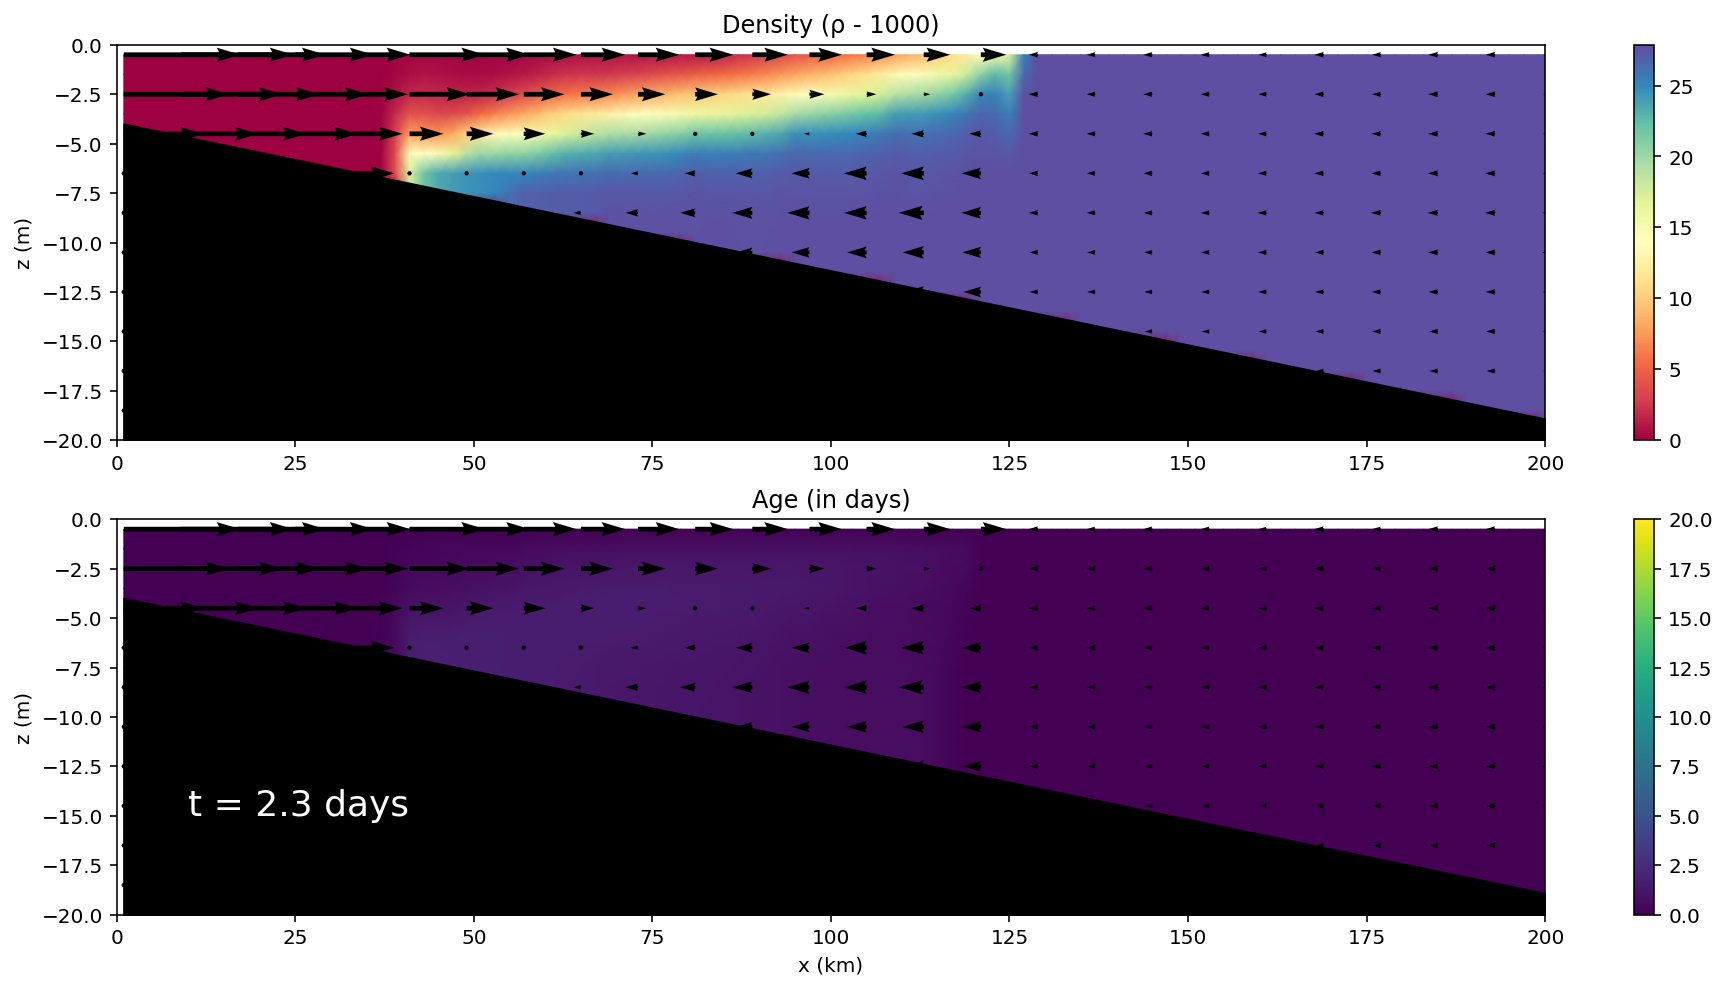

In [188]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# show time in units of days
t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'D')
    
x = ds.x / 1000
z = -ds.z
x, z = np.meshgrid(x, z)

n = 28

pmesh = ax1.pcolormesh(x, z, ds.rho[n].T, cmap='Spectral', shading='gouraud')

fig.colorbar(pmesh, ax=ax1)

ax1.quiver(x[::2,::4], z[::2,::4], ds.u[n].T[::2,::4], ds.w[n].T[::2,::4], scale=20)

# draw bathymetry
ax1.fill_between(ds.x / 1000, -H+1, -21, color='k')
ax1.set_title('Density (ρ - 1000)')

pmesh = ax2.pcolormesh(x, z, ds.age[n].T / (3600*24), cmap='viridis', shading='gouraud', vmin =0, vmax=20)

fig.colorbar(pmesh, ax=ax2)

ax2.quiver(x[::2,::4], z[::2,::4], ds.u[n].T[::2,::4], ds.w[n].T[::2,::4], scale=20)
# draw bathymetry
ax2.fill_between(ds.x / 1000, -H+1, -21, color='k')
ax2.set_title('Age (in days)')

ax1.set_xlim(0, 200)
ax1.set_ylim(-20, 0)
ax2.set_xlim(0, 200)
ax2.set_ylim(-20, 0)
ax2.set_xlabel('x (km)')
ax1.set_ylabel('z (m)')
ax2.set_ylabel('z (m)')

ax2.text(10, -15, f't = {t[n]:.1f} days ', color='white', size=18)
plt.show()

In [184]:
def animate(filename):
    ds = xr.open_dataset(filename)
    
    ηriver = float(filename.split('_')[-1][:-3])*100
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

    # show time in units of days
    t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'D')
    
    x = ds.x / 1000
    z = -ds.z
    x, z = np.meshgrid(x, z)


    pmesh1 = ax1.pcolormesh(x, z, ds.rho[n].T, cmap='Spectral', shading='gouraud')

    fig.colorbar(pmesh1, ax=ax1)

    q1 = ax1.quiver(x[::2,::4], z[::2,::4], ds.u[n].T[::2,::4], ds.w[n].T[::2,::4], scale=20)

    # draw bathymetry
    ax1.fill_between(ds.x / 1000, -H+1, -21, color='k')

    pmesh2 = ax2.pcolormesh(x, z, ds.age[0].T / (3600*24), cmap='viridis',  shading='gouraud', vmin =0, vmax=20)

    fig.colorbar(pmesh2, ax=ax2)

    q2 = ax2.quiver(x[::2,::4], z[::2,::4], ds.u[0].T[::2,::4], ds.w[0].T[::2,::4], scale=20)
    # draw bathymetry
    ax2.fill_between(ds.x / 1000, -H+1, -21, color='k')
    
    text = ax1.text(10, -15, f'$\eta_{{river}} = {ηriver:.0f}$ cm', color='white', size=18)
    
    text = ax2.text(10, -15, f'time = {t[0]:.1f} days', color='white', size=18)
    
    def init():
        ax1.set_title('Density (ρ - 1000)')
        ax2.set_title('Age (in days)')

        ax1.set_xlim(0, 200)
        ax1.set_ylim(-20, 0)
        ax2.set_xlim(0, 200)
        ax2.set_ylim(-20, 0)
        ax2.set_xlabel('x (km)')
        ax1.set_ylabel('z (m)')
        ax2.set_ylabel('z (m)')

        ax1.axvline(120, color='w', linestyle='--', linewidth =2)
        ax1.text(122, -17.5, 'Mouth', color='white', size=16)
        ax2.axvline(120, color='w', linestyle='--', linewidth =2)
        
        return pmesh1, pmesh2, q1, q2, text
    
    def update(frame):

        q1.set_UVC( ds.u[frame].T[::2,::4], ds.w[frame].T[::2,::4] )
        q2.set_UVC( ds.u[frame].T[::2,::4], ds.w[frame].T[::2,::4] )
        pmesh1.set_array(ds.rho[frame].values.T.flatten())
        pmesh2.set_array(ds.age[frame].values.T.flatten()/ (3600*24))
        
        text.set_text(f'time = {t[frame]:.1f} days')
        
        return pmesh1, pmesh2, q1, q2, text
        
        
    anim = FuncAnimation(fig, update, blit=True,
                         init_func=init,
                         frames=len(ds.time),
                        )
    plt.close(fig)
    
    return anim

### Salt-Wedge Estuary

In [192]:
filename = 'src/AOM_Ex14/output_0.30.nc'
anim = animate(filename)

moviefile = 'Lecture16_0.30.mp4'
anim.save(moviefile, writer='ffmpeg', fps=5, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

### Highly Stratified Estuary

In [191]:
filename = 'src/AOM_Ex14/output_0.05.nc'
anim = animate(filename)

moviefile = 'Lecture16_0.05.mp4'
anim.save(moviefile, writer='ffmpeg', fps=5, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

### Vertically Mixed Estuary

In [190]:
filename = 'src/AOM_Ex14/output_0.01.nc'
anim = animate(filename)

moviefile = 'Lecture16_0.01.mp4'
anim.save(moviefile, writer='ffmpeg', fps=5, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

> **Problem 22**: Run Exercise 14 on your own and complete 3.25.6 Additional Exercise for the Reader:
>
> Add a sill near the estuary's mouth and explore changes in both the
dynamics and water age distributions. ~The reader should also try to calculate flushing times based on an e-folding timescale and to compare the results with the
predicted age distribution.~

# AOM Chapter 4: 2.5D Vertical Slice Modelling

## AOM 4.1 The Basis

### 4.1.1 Adding Another Half Dimension
Elongated dynamical features being influenced by the Coriolis force, such as oceanic
fronts, can be described to first-order approximation by the dynamics in a vertical
ocean slice with vanishing gradients of all variables normal to this slice (Fig. 4.1).
This approach is called the *2.5-dimensional vertical ocean-slice model*.



### 4.1.2 - 4.1.5

Read and review (but I think we already covered all of this in the first textbook and/or PHYS6310)

### The 2.5d Shallow-Water Model

See equations 4.14 and 4.15

### Implementation of the Coriolis Force

See text and OMB 3.14.

## AOM 4.2 Exercise 16: Geostrophic Adjustment


### 4.2.1 Aim

This exercise employs the 2.5d vertical ocean-slice model to study geostrophic
adjustment of a surface density front of infinite length.

### 4.2.2 Task Description

Grid
- Model domain:  50 km in length and 500 m in depth
- Grid spacing: Δx = 500 m,  Δz = 10 m.
- Lateral boundaries are closed. 

Forcing
- An isolated surface layer of 10 km wide, 250 m thick place in centre of domain (See Fig. 4.3).
- Density is of layer is 0.1 kg/m3 lighter than the ambient ocean.
- Density anomaly of the surface layer is linearly adjusted from zero to a final value over the first 6 hrs of the simulation
- No further forcing is applied afterward and the dynamics can evolve freely.

See text for for specific details of other parameters.

### 4.2.3 Results

In [246]:
def animate(filename):
    ds = xr.open_dataset(filename)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))

    # show time in units of hours
    t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'h')
    
    x = ds.x / 1000
    z = -ds.z
    x, z = np.meshgrid(x, z)

    pmesh_ρ = ax1.pcolormesh(x, z, ds.rho[0].T, cmap='Spectral', vmin=-0.1, vmax=0, shading='gouraud')
    pmesh_u = ax2.pcolormesh(x, z, ds.u[0].T, cmap='viridis', vmin = -20, vmax=20, shading='gouraud')
    pmesh_v = ax3.pcolormesh(x, z, ds.v[0].T, cmap='viridis', vmin = -20, vmax=20, shading='gouraud')

    fig.colorbar(pmesh_ρ, ax=ax1)
    fig.colorbar(pmesh_u, ax=ax2)
    fig.colorbar(pmesh_v, ax=ax3)
     
    ax1.text(5, -90, "ρ' (kg/m$^3$)", color='white', size=16)
    ax2.text(5, -90, "u (cm/s)", color='white', size=16)
    ax3.text(5, -90, "v (cm/s)", color='white', size=16)
    
    text = ax1.set_title(f'Time = {t[0]:.0f} h', size=16)
    
    
    def init():
     
        ax1.set_xlim(0, 50)
        ax1.set_ylim(-500, 0)
        ax2.set_xlim(0, 50)
        ax2.set_ylim(-500, 0)
        ax3.set_xlim(0, 50)
        ax3.set_ylim(-500, 0)
        
        ax3.set_xlabel('x (km)')
        ax1.set_ylabel('z (m)')
        ax2.set_ylabel('z (m)')
        ax3.set_ylabel('z (m)')

        ax1.axvline(120, color='w', linestyle='--', linewidth =2)
        ax1.text(122, -17.5, 'Mouth', color='white', size=16)
        ax2.axvline(120, color='w', linestyle='--', linewidth =2)
        
        return pmesh_ρ, pmesh_u, pmesh_v, text
    
    def update(frame):

        pmesh_ρ.set_array(ds.rho[frame].values.T.flatten())
        pmesh_u.set_array(ds.u[frame].values.T.flatten()*100)
        pmesh_v.set_array(ds.v[frame].values.T.flatten()*100)
        
        text.set_text(f'Time = {t[frame]:.0f} h')
        
        return pmesh_ρ, pmesh_u, pmesh_v, text
        
        
    anim = FuncAnimation(fig, update, blit=True,
                         init_func=init,
                         frames=len(ds.time),
                        )
    plt.close(fig)
    
    return anim

#### Scenario 1: No Coriolis force

sub.f95, line 44:

`f = 0. ! Coriolis parameter`

In [247]:
filename = 'src/AOM_Ex16/output_nocoriolis.nc'
anim = animate(filename)

moviefile = 'Lecture16_nocoriolis.mp4'
anim.save(moviefile, writer='ffmpeg', fps=2, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

#### Scenario 2: Coriolis force

sub.f95, line 44:

`f = 1.e-4 ! Coriolis parameter`

In [248]:
filename = 'src/AOM_Ex16/output_coriolis.nc'
anim = animate(filename)

moviefile = 'Lecture16_coriolis.mp4'
anim.save(moviefile, writer='ffmpeg', fps=2, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

## AOM 4.3 Exercise 17: Tidal Mixing Fronts

### 4.3.1 Background

See text.

### 

### 4.3.2 Task Description

Grid
- Model domain: 10 km in length. 
- Grid spacing: Δx = 100 m, Δz = 2 m 
- Water depth linearly decreases from 100 m at one side to 50 m at the other side of the domain (See Fig. 4.7). 
- Lateral boundaries are closed. 

Stratification
- Initially, the water column is stably stratified.
- The surface mixed layer is 20 m thick and has a density of ρ = 1,027 kg/m3. 
- The density of seawater underneath is set to ρ = 1,028 kg/m3. 

Forcing
- Background values of vertical eddy viscosity and eddy diffusivity are set for entire domain
$$A_{z,b} = K_{z,b} = 5\times 10^{-4} \mbox{m}^2/\mbox{s}$$
- Tidal currents are *not* explicitly forced. Tidal mixing is *parameterized*.
- Enhanced turbulenced levels are set in regions shallower than 60 m with maximum values of
$$A_{z,\mbox{max}} = K_{z,\mbox{max}} = 5\times 10^{-2} \mbox{m}^2/\mbox{s}$$
- Tidal cycle is emulated according to
$$A_{z} = K_{z} = A_{z,\mbox{max}} | \sin(2\pi t/T)| + A_z, b$$


See text for for specific details of other parameters.

### Results 4.3.3

In [199]:
bathyfile = 'src/AOM_Ex17/h.dat'
H = np.loadtxt(bathyfile)

In [230]:
def animate(filename):
    ds = xr.open_dataset(filename)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8))

    # show time in units of hours
    t = (ds.time - ds.time[0]).values / np.timedelta64(1, 'h')
    
    x = ds.x / 1000
    z = -ds.z
    x, z = np.meshgrid(x, z)

    pmesh_ρ = ax1.pcolormesh(x, z, ds.rho[0].T, cmap='Spectral', shading='gouraud')
    pmesh_u = ax2.pcolormesh(x, z, ds.u[0].T, cmap='viridis', vmin = -10, vmax=10, shading='gouraud')
    pmesh_v = ax3.pcolormesh(x, z, ds.v[0].T, cmap='viridis', vmin = -20, vmax=20, shading='gouraud')

    fig.colorbar(pmesh_ρ, ax=ax1)
    fig.colorbar(pmesh_u, ax=ax2)
    fig.colorbar(pmesh_v, ax=ax3)
    
    # draw bathymetry
    ax1.fill_between(ds.x / 1000, -H, -100, color='k')
    ax2.fill_between(ds.x / 1000, -H, -100, color='k')
    ax3.fill_between(ds.x / 1000, -H, -100, color='k')
  
    ax1.text(8, -90, "ρ' (kg/m$^3$)", color='white', size=16)
    ax2.text(8, -90, "u (cm/s)", color='white', size=16)
    ax3.text(8, -90, "v (cm/s)", color='white', size=16)
    
    text = ax1.set_title(f'Time = {t[0]:.0f} h', size=16)
    
    
    def init():
     
        ax1.set_xlim(0, 10)
        ax1.set_ylim(-100, 0)
        ax2.set_xlim(0, 10)
        ax2.set_ylim(-100, 0)
        ax3.set_xlim(0, 10)
        ax3.set_ylim(-100, 0)
        
        ax3.set_xlabel('x (km)')
        ax1.set_ylabel('z (m)')
        ax2.set_ylabel('z (m)')
        ax3.set_ylabel('z (m)')

        ax1.axvline(120, color='w', linestyle='--', linewidth =2)
        ax1.text(122, -17.5, 'Mouth', color='white', size=16)
        ax2.axvline(120, color='w', linestyle='--', linewidth =2)
        
        return pmesh_ρ, pmesh_u, pmesh_v, text
    
    def update(frame):

        pmesh_ρ.set_array(ds.rho[frame].values.T.flatten())
        pmesh_u.set_array(ds.u[frame].values.T.flatten()*100)
        pmesh_v.set_array(ds.v[frame].values.T.flatten()*100)
        
        text.set_text(f'Time = {t[frame]:.0f} h')
        
        return pmesh_ρ, pmesh_u, pmesh_v, text
        
        
    anim = FuncAnimation(fig, update, blit=True,
                         init_func=init,
                         frames=len(ds.time),
                         #frames=2
                        )
    plt.close(fig)
    
    return anim

In [231]:
filename = 'src/AOM_Ex17/output.nc'
anim = animate(filename)

moviefile = 'Lecture16_tidalmixing.mp4'
anim.save(moviefile, writer='ffmpeg', fps=5, dpi=200)

HTML(f'<center><video controls autoplay src="{moviefile}" width=100%/></center>')

> **Problem 23**: Tidal Mixing Front
>
> - Read 4.3.4 and recreate Figure AOM 4.10
> - Repeat this exercise with an initial density difference between the top and the bottom
layers of Δρ = 2 kg m−3, which is twice that used before, and explore the features
of the resultant tidal mixing front and associated flows.